In [1]:
from pennystockpipeline.PennyStockData import PennyStockData
import torch

torch.manual_seed(0)

## Initializing
DATABASE_NAME_WITH_PATH = "mod_historicaldata.db"
TABLE_NAME = "all_historical_modified"

#psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(['close', 'volume_weighted_average']).create_sequences(sequence_length, prediction_length)
psd = PennyStockData(DATABASE_NAME_WITH_PATH, TABLE_NAME, impute=True, verbose=2)


[DEBUG][PennyStockData]: Imputed len(data): 104295
next_max_date: 2024-06-01


In [2]:
#columns = ['ticker_id', 'p_date', 'close', 'volume_weighted_average']
COLUMNS = ['ticker_id', 'p_date', 'p_time', 'volume_weighted_average']
COLUMNS_TO_NORMALIZE = ['volume_weighted_average']

SEQUENCE_LENGTH = 20
PREDICTION_LENGTH = 20

TRAIN_TEST_SPLIT = 0.8
psd = psd.get_columns(COLUMNS).normalize(COLUMNS_TO_NORMALIZE).create_sequences(SEQUENCE_LENGTH, PREDICTION_LENGTH).split_dataset(split=TRAIN_TEST_SPLIT, to_torch=True)


[INFO][PennyStockData]: Performing ticker-wise normalization on ['volume_weighted_average']
[INFO][PennyStockData]: Performing global normalization on ['volume_weighted_average'] using MixMaxScaler
x_train.shape: (3964, 20, 1), y_train.shape: (3964, 20, 1)
x_test.shape: (991, 20, 1), y_test.shape: (991, 20, 1)


In [3]:
#model = None

In [4]:
# Library for implementing Deep Neural Network 
from pennystockpipeline.PennyStockModel import PennyStockModel

# Prepare model parameters
INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 2
HIDDEN_SIZE = 64
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
DROPOUT = 0
# Define the model, loss function, and optimizer
model = PennyStockModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT, device='cuda')
model = model.to(model.device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


PennyStockModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [5]:
BATCH_SIZE = 32   # batch 16, run epoch 40; batch 32, run epoch 40 or 50 with torch.random_seed(0)
model = model.create_dataloaders(psd, BATCH_SIZE)


#torch.random_seed(0), 
#batch = 32								batch = 16
#model	epoch=40						model	epoch=40
#best_loss: 0.0020826306399612804		best_loss: 0.004081749377291999
#diff	0.0005							diff	0.0003

#torch.random_seed(0), 
#batch = 32								batch = 16
#model	epoch=50						model	epoch=50
#best_loss: 0.002037114063568879		best_loss: 0.004062295620315126
#diff	-0.0003							diff	0.0034

## can we use transfer learning

best_loss: 0.22535117669031024 @ epoch: 0
best_loss: 0.07672516815364361 @ epoch: 1
best_loss: 0.020810206537134945 @ epoch: 2
best_loss: 0.005685944881406613 @ epoch: 3
best_loss: 0.0036580386658897623 @ epoch: 4
best_loss: 0.0029257270398375113 @ epoch: 5
best_loss: 0.0025177956576953875 @ epoch: 6
best_loss: 0.002309479965333594 @ epoch: 7
Epoch [10/50] - Training Loss: 0.000089, Test Loss: 0.000079
best_loss: 0.00221371970292239 @ epoch: 11
best_loss: 0.0021717829949920997 @ epoch: 16
best_loss: 0.002106874129822245 @ epoch: 18
Epoch [20/50] - Training Loss: 0.000100, Test Loss: 0.000086
Epoch [30/50] - Training Loss: 0.000083, Test Loss: 0.000087
best_loss: 0.0020826315576414345 @ epoch: 34
Epoch [40/50] - Training Loss: 0.000089, Test Loss: 0.000070
best_loss: 0.0020429132509889314 @ epoch: 41
best_loss: 0.0020371126656755223 @ epoch: 44
Epoch [50/50] - Training Loss: 0.000086, Test Loss: 0.000068


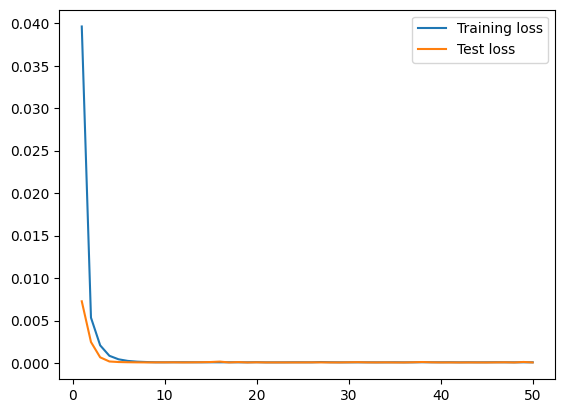

In [6]:
NUM_EPOCHS = 50
# Train the model
#model = model.load_model()

model = model.train_model(loss_fn, optimizer, num_epochs = NUM_EPOCHS).plot_training_test_loss()#.save_model()


In [7]:
FORECAST_STEPS = 20
model = model.forecast(num_forecast_steps = FORECAST_STEPS)


original_cases:
[0.48151296 0.48151296 0.48133895 0.48133895 0.48133895 0.47975323
 0.47975323 0.47975323 0.47975323 0.48151296 0.48151296 0.48151296
 0.48149368 0.48149368 0.48149368 0.48149368 0.4795792  0.4795792
 0.4795792  0.4795792 ]
forecasted_cases:
[0.48128498 0.48128498 0.48110595 0.48110595 0.48110595 0.47947457
 0.47947457 0.47947457 0.47947457 0.48128498 0.48128498 0.48128498
 0.48126504 0.48126504 0.48126504 0.48126504 0.47929555 0.47929555
 0.47929555 0.47929555 0.48105043 0.48105043 0.4808662  0.4808662
 0.4808662  0.47918794 0.47918794 0.47918794 0.47918794 0.48105043
 0.48105043 0.48105043 0.4810299  0.4810299  0.4810299  0.4810299
 0.47900376 0.47900376 0.47900376 0.47900376]


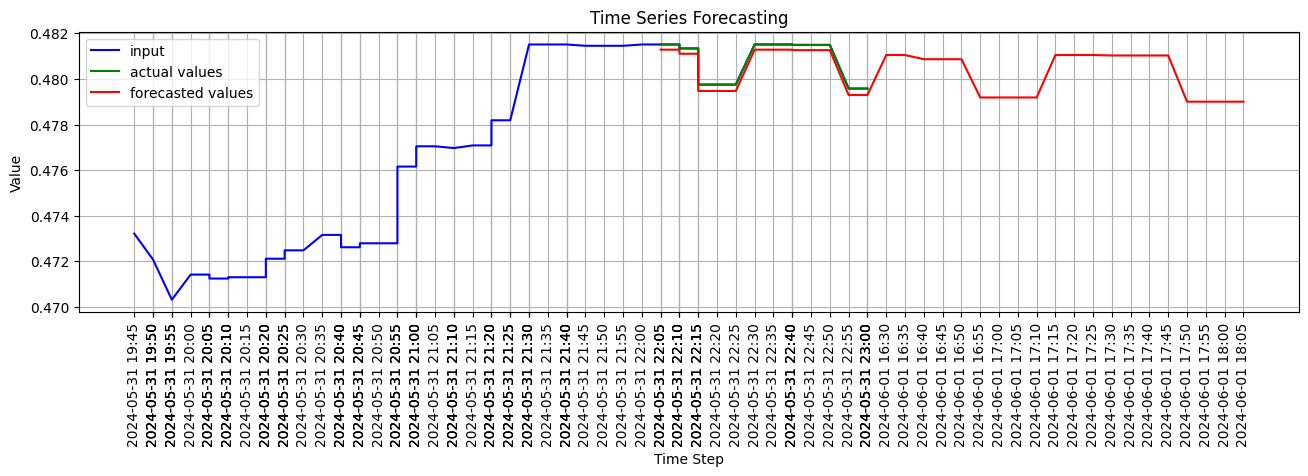

In [8]:
#model = model.load_model()
model = model.plot_forecasting()#, i_sequence_to_plot, i_forecasted_values, i_combined_index)


In [9]:
#model = model.save_model()

In [10]:
'''
# Library for implementing Deep Neural Network 
psd2 = psd

from pennystockpipeline.PennyStockModel2 import PennyStockModel2

# Prepare model parameters
INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 2
HIDDEN_SIZE = 32
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
DROPOUT = 0.2

# Define the model, loss function, and optimizer
model2 = PennyStockModel2(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT, device='cuda')
model2 = model2.to(model2.device)
loss_fn2 = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
print(model2)

BATCH_SIZE = 64
model2 = model2.create_dataloaders(psd2, BATCH_SIZE)
NUM_EPOCHS = 100
# Train the model
#model2 = model2.load_model()
model2 = model2.train_model(loss_fn2, optimizer2, num_epochs = NUM_EPOCHS).plot_training_test_loss()#.save_model()

model2 = model2.forecast(num_forecast_steps = FORECAST_STEPS)
model2 = model2.plot_forecasting()#, i_sequence_to_plot, i_forecasted_values, i_combined_index)
'''

"\n# Library for implementing Deep Neural Network \npsd2 = psd\n\nfrom pennystockpipeline.PennyStockModel2 import PennyStockModel2\n\n# Prepare model parameters\nINPUT_SIZE = len(COLUMNS_TO_NORMALIZE)\nNUM_LAYERS = 2\nHIDDEN_SIZE = 32\nOUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)\nDROPOUT = 0.2\n\n# Define the model, loss function, and optimizer\nmodel2 = PennyStockModel2(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT, device='cuda')\nmodel2 = model2.to(model2.device)\nloss_fn2 = torch.nn.MSELoss(reduction='mean')\noptimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)\nprint(model2)\n\nBATCH_SIZE = 64\nmodel2 = model2.create_dataloaders(psd2, BATCH_SIZE)\nNUM_EPOCHS = 100\n# Train the model\n#model2 = model2.load_model()\nmodel2 = model2.train_model(loss_fn2, optimizer2, num_epochs = NUM_EPOCHS).plot_training_test_loss()#.save_model()\n\nmodel2 = model2.forecast(num_forecast_steps = FORECAST_STEPS)\nmodel2 = model2.plot_forecasting()#, i_sequence_to_plot, i_forecasted_value